In retrospect, this code is more applicable to quadcopters and helicopters than it is to conventional airplanes. Basic dynamics have been met, obstacles are avoided, and a firm appreciation of weights, constraints, and complaints has been fostered. 

This code begins with a randomized guess; after some time of minimizing, if the error is larger than a prescribed error goal, then a new random guess is made. This process repeats until the error goal is satisfied and we are able to plot what the program was able to come up with.

More constraints could be added to resemble flight paths for other classes and categories of aircraft. Feel free to experiment; add/subtract from the dynamics as you care to. 

I hope this helps.

# Imports

In [7]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from copy import copy

# Defs and Constants

In [8]:
# Define basis functions (polynomials)
def basis_functions(t, order):
    basis = [t**i for i in range(order+1)]
    return np.vstack(basis).T

# Generate initial guesses for coefficients
def initial_guess(order):
    # return np.zeros(4*(order+1))
    return np.random.random_sample(size = 4*(order+1))

# Define trajectory function using polynomial coefficients
def trajectory(coeffs, t):
    basis = basis_functions(t, len(coeffs)-1)
    return np.dot(basis, coeffs)

# Compute thrust and moment
def compute_thrust_and_moment(coeffs, t):
    V = trajectory(coeffs[3*(order+1):], t)  # Velocity
    Vd = np.gradient(trajectory(coeffs[3*(order+1):], t), t)  # Acceleration (derivative of velocity)

    THd = np.gradient(trajectory(coeffs[2*(order+1):3*(order+1)], t), t)  # Angular velocity
    THdd = np.gradient(THd, t)  # Angular acceleration

    moment = i_z * THdd  # Adjust some_constant as needed
    thrust = mass * Vd  # Adjust some_other_constant as needed
    return thrust, moment

# Plot thrust and moment
def plot_thrust_and_moment(thrust, moment, t):
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, thrust, 'b', label='Thrust')
    plt.xlabel('Time')
    plt.ylabel('Thrust')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(t, moment, 'r', label='Moment')
    plt.xlabel('Time')
    plt.ylabel('Moment')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


#Dynamic constants adjust as needed
maxThrust = .7
maxMoment = .7 * 180 / np.pi
mass = 1
i_z = 1

#weights
weight_upper = 100
weight_lower = 100
vel_weight = 1000

# Define obstacle positions and shapes

ob_x = .3
ob_y = .2
ob_r = .02

obstacles = []

for i in range(2,8):
  for g in range(2,8):
    obstacles.append(( .1*i , .1*g  ,ob_r))

obst = plt.Circle((ob_x,ob_y), ob_r)

# Error Function


In [9]:
def error_function(coeffs, t):
    X = trajectory(coeffs[:len(coeffs)//4], t)
    Y = trajectory(coeffs[len(coeffs)//4:2*len(coeffs)//4], t)
    TH = trajectory(coeffs[2*len(coeffs)//4:3*len(coeffs)//4], t)
    V = trajectory(coeffs[3*len(coeffs)//4:], t)

    Xd = np.gradient(X, t)
    Yd = np.gradient(Y, t)
    Vd = np.gradient(V, t)      # Compute the derivative of velocity -> acceleration -> thrust/mass
    THd = np.gradient(TH, t)    # First derivative of steering angle (angular velocity)
    THdd = np.gradient(THd, t)  # Second derivative of steering angle (angular acceleration)

    e_xdot = np.sum((Xd - V*np.cos(TH))**2)
    e_ydot = np.sum((Yd - V*np.sin(TH))**2)

    # Initial condition
    x0, y0 = 0, 0
    eIC = 1000*(X[0] - x0)**2  + 1000*(Y[0] - y0)**2  + 10*TH[0]**2 + vel_weight*V[0]**2
    # print('eIC = ',eIC)

    # Final condition
    xf, yf = 1, 1
    eFC = 1000*(X[-1] - xf)**2 + 1000*(Y[-1] - yf)**2 + 10*(TH[-1]-np.pi)**2 + vel_weight*V[-1]**2
    # print('eFC = ',eFC)

    # Constraint on acceleration: derivative of velocity should be within a certain range
    upper = (0, Vd - maxThrust)
    upper = (upper[0],) + tuple(upper[1])
    # print(upper)

    lower = (0, -maxThrust - Vd)
    lower = (lower[0],) + tuple(lower[1])

    upper_bound_violation = max(upper)**2
    lower_bound_violation = max(lower )**2
    acceleration_constraint = weight_upper*upper_bound_violation + weight_lower*lower_bound_violation
    # print('acceleration const = ',acceleration_constraint)

    # Constraint on angular acceleration: second derivative of steering angle should be within a certain range
    upper = (0, THdd - maxMoment)
    upper = (upper[0],) + tuple(upper[1])

    lower = (0, -maxMoment- THdd)
    lower = (lower[0],) + tuple(lower[1])

    upper_bound_violation = max(upper)**2
    lower_bound_violation = max(lower )**2
    angular_acceleration_constraint = weight_upper*upper_bound_violation + weight_lower*lower_bound_violation
    # print('angle acceleration const = ',acceleration_constraint)

    # Add the constraint term to the error function
    error_with_constraint = e_xdot + e_ydot + 10*eIC + 10*eFC + (angular_acceleration_constraint) + ( acceleration_constraint)  # Adjust weights as needed
    # print('error w const = ',error_with_constraint)


    # Penalty for proximity to obstacles
    obstacle_penalty = 0
    for obstacle in obstacles:
        obstacle_x, obstacle_y, obstacle_radius = obstacle
        distance_to_obstacle = np.sqrt((X - obstacle_x)**2 + (Y - obstacle_y)**2)
        obstacle_penalty += np.sum(np.maximum(0, obstacle_radius - distance_to_obstacle)**2)

    # print('obst penalty =', obstacle_penalty)
    total_error = error_with_constraint + obstacle_penalty*10000000
    # print('Error: ',total_error)

    return total_error


# Training Prep

In [10]:
# Define parameters
order = 6  # Order of polynomials
nPts = 50
T = np.linspace(0, 1, nPts)

# Initial guess for coefficients
initial_coeffs = initial_guess(order)

# print(initial_coeffs)

# Training

In [11]:
# iter = 10000
# for i in range(0,iter):
#   # Minimize the error function to find optimal coefficients
#   opt_coeffs = opt.minimize(error_function, initial_coeffs, args=(T,), method='BFGS').x
# error_function(initial_coeffs, T)

while True:
  opt_coeffs = opt.minimize(error_function, initial_coeffs, args=(T,), method='BFGS').x   #, method='BFGS'    Nelder-Mead      CG

  # if the initial guess was not good, restart with a new inital guess until the error shows a convergance we want
  errorGoal = 150
  if error_function(opt_coeffs,T) > errorGoal:
    print('bad guess, trying again. Error = ',error_function(initial_coeffs,T),  '   initial_guess(order) = ', initial_coeffs)
    initial_coeffs = initial_guess(order)

  if error_function(opt_coeffs,T) < errorGoal:
    print('WE GOT ONE YAAAY')
    break

# opt_coeffs = opt.minimize(error_function, initial_coeffs, args=(T,), method='BFGS').x   #, method='BFGS'    Nelder-Mead      CG

# print(error_function(opt_coeffs,T))

# print(error_function(initial_coeffs,T) )
# print(opt_coeffs)
initial_coeffs = opt_coeffs

WE GOT ONE YAAAY


# Plots


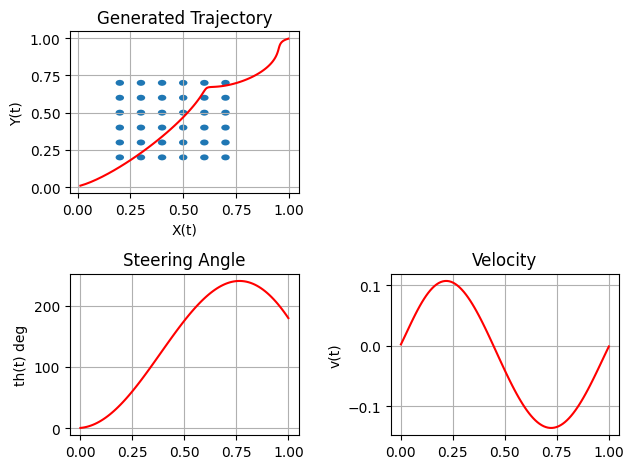

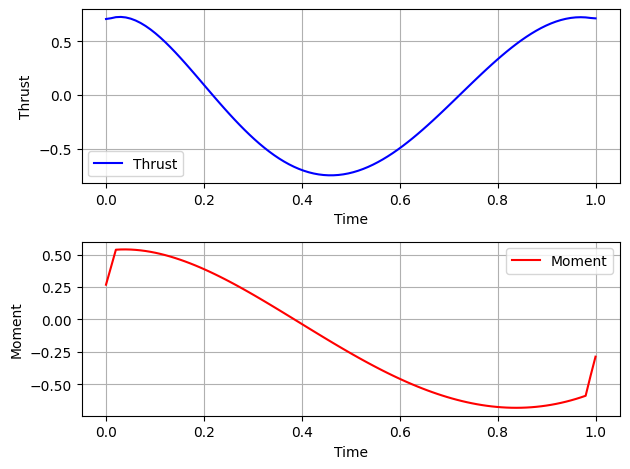

In [12]:
TT = np.linspace(0, 1, 100)
X = trajectory(opt_coeffs[:order+1], TT)
Y = trajectory(opt_coeffs[order+1:2*(order+1)], TT)
TH = trajectory(opt_coeffs[2*(order+1):3*(order+1)], TT)
V = trajectory(opt_coeffs[3*(order+1):], TT)

plt.subplot(2, 2, 1)
plt.plot(X, Y, 'r')
plt.grid(True)
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.title('Generated Trajectory')

for obstacle in obstacles:
    obstacle_x, obstacle_y, obstacle_radius = obstacle
    obst = plt.Circle((obstacle_x,obstacle_y), obstacle_radius)

    copy_obst = copy(obst)
    plt.gca().add_patch(copy_obst)

plt.subplot(2, 2, 3)
plt.plot(TT, TH*180/np.pi, 'r')
plt.grid(True)
plt.ylabel('th(t) deg')
plt.title('Steering Angle')

plt.subplot(2, 2, 4)
plt.plot(TT, V, 'r')
plt.grid(True)
plt.ylabel('v(t)')
plt.title('Velocity')

plt.tight_layout()
plt.show()

thrust, moment = compute_thrust_and_moment(opt_coeffs, TT)
moment = moment / 180 * np.pi

plot_thrust_and_moment(thrust, moment, TT)
plt.show()

Flight goals:
- Avoid obstacles

- Enforce initial and final conditions (position, heading, velocity)

- Reduce thrust and moment loads; if a pilot is operating this machine they should not be harmed